# Rodeo algorithm in qiskit runtime

## March 2023

### To do next:
- Add noise models
- More scrambling of $t$ values
- Allow more interesting pauli hamiltonians

## Import statements

In [1]:
# Import statements
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService
from qiskit.opflow import I, X, Y, Z, PauliOp, MatrixEvolution, MatrixOp
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt

## Helpful definition

In [2]:
def zsum(t: Parameter, nqubits, coeffs):
    """ Creates time evolution operator for non-interacting qubits. Default is Z.
    """
    circ = QuantumCircuit(nqubits)
    for q in range(nqubits):
        circ.rz(2 * t*coeffs[q], q) 
        
    return circ.to_gate(label = r'$\otimes R_z$')

def rodeo_cycle(U, t:Parameter, targ:Parameter, sysqubits:int, coeffs):
    """Prepares a unitary quantum gate for a single cycle of the rodeo algorithm
    without measurements. Contains the parameters t and targ.
    """
    # Prepare registers
    aux = QuantumRegister(1,'a')
    sys = QuantumRegister(sysqubits, 's')
    circuit = QuantumCircuit(aux, sys)
    
    # Add Hadamard test gates
    circuit.h(aux)
    circuit.append(U(t, sysqubits, coeffs).control(1), range(1+sysqubits))
    circuit.p(targ * t,aux)
    circuit.h(aux)
    return circuit.to_gate(label=r'$RA_{cyc}$')

## Construct Rodeo circuit

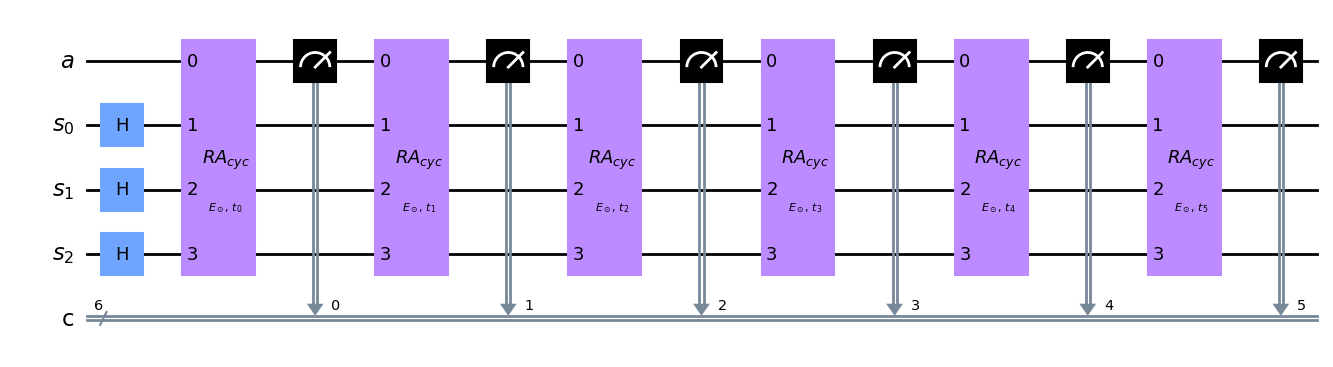

In [3]:
# General parameters
cycles = 6
sys_size = 3

# Circuit parameters
targ = Parameter(r'$E_\odot$')
t = [Parameter(fr'$t_{i}$') for i in range(cycles)]

# Hamiltonian parameters
ham_params = [-1,.5,2.75]

# Create registers and initialize circuit
cbits = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(sys_size, 's')
circ = QuantumCircuit(cbits, aux, sys)

# State prep
circ.h(sys)

# Iteratively construct full rodeo circuit
for cyc in range(cycles):
    circ.append(rodeo_cycle(zsum, t[cyc], targ, sys_size, ham_params), range(1 + sys_size))
    circ.measure(aux, cbits[cyc])
circ.draw(output= 'mpl')

## Do a Rodeo scan

In [24]:
# Enumerate scan energies
energymin = -10
energymax = 10
stepsize = .1

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))

# Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 10 * stepsize

# Package parameters into runs of rodeo circuit
params = []
for i, energy in enumerate(targetenergies):
    tsamples = list(1/gamma * np.random.randn(cycles)) # Choose random t samples
    params = params + [[targetenergies[i]] + tsamples] # Append parameters to params list
runs = len(params)

# Execute circuit with bound parameters
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")
sampler = Sampler(session=backend)
job = sampler.run([circ]*runs, params, shots = 1020)
result = job.result()
probs = result.quasi_dists

# Extract all-zero normalized counts
allzeroprob = [0]*len(probs)

for i, dist in enumerate(probs):
    try:
        allzeroprob[i] = probs[i][0]
    except KeyError:
        allzeroprob[i] = 0

## Plot results

Text(0.5, 1.0, 'Rodeo scan with $\\Gamma = 1.0$')

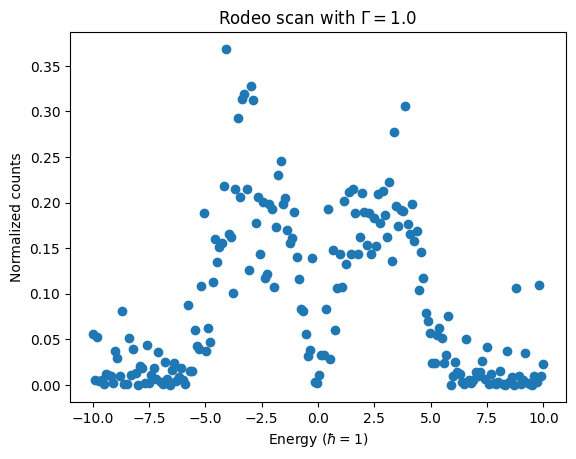

In [25]:
# Plot results
plt.plot(targetenergies, allzeroprob, linestyle = "None",marker = 'o')
plt.ylabel("Normalized counts")
plt.xlabel(r"Energy ($\hbar = 1$)")
plt.title(r"Rodeo scan with $\Gamma = {}$".format(round(gamma,2)))